<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN_RESNET50_COUNT_PALM_TREES_FULL_PROGRAM/blob/main/FASTER_RCNN_RESNET50_COUNT_PALM_TREES_FULL_PROGRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATASET

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("cryospace-yylkk").project("palm-tree-label-200m-splitted")
version = project.version(4)
dataset = version.download("voc")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Tree-Label-200m-Splitted-4 in voc:: 100%|██████████| 869/869 [00:01<00:00, 532.39it/s]


In [ ]:
# Membuat folder images dan annotations
!mkdir -p images annotations

In [ ]:
import os
import shutil

# Daftar folder sumber
folders = ['/content/Palm-Tree-Label-200m-Splitted-4/test', '/content/Palm-Tree-Label-200m-Splitted-4/train', '/content/Palm-Tree-Label-200m-Splitted-4/valid']

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

# Memindahkan file berdasarkan ekstensi
for folder in folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Memindahkan file .xml ke /content/annotations
        if filename.endswith('.xml'):
            shutil.move(file_path, '/content/annotations/')

        # Memindahkan file .png, .jpg, atau .jpeg ke /content/images
        elif filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.move(file_path, '/content/images/')

In [ ]:
import os
import random
import numpy as np
import shutil

# Menghitung dan mencetak jumlah file di folder annotations dan images
print(f'Jumlah file di annotations: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images: {len(os.listdir("images"))}')

# Membuat folder test_images dan test_annotations
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Mengatur seed untuk reproducibility
random.seed(1234)

# Menghitung jumlah dataset
total_data = 432
test_data_count = int(0.15 * total_data)  # 15% dari total_data

# Mengambil indeks secara acak untuk 15% data
idx = random.sample(range(total_data), test_data_count)

# Memindahkan file gambar ke test_images
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move(os.path.join('images', img), os.path.join('test_images', img))

# Memindahkan file anotasi ke test_annotations
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move(os.path.join('annotations', annot), os.path.join('test_annotations', annot))

# Menghitung dan mencetak jumlah file setelah pemindahan
print(f'Jumlah file di annotations setelah pemindahan: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images setelah pemindahan: {len(os.listdir("images"))}')
print(f'Jumlah file di test_annotations: {len(os.listdir("test_annotations"))}')
print(f'Jumlah file di test_images: {len(os.listdir("test_images"))}')

Jumlah file di annotations: 432
Jumlah file di images: 432
Jumlah file di annotations setelah pemindahan: 368
Jumlah file di images setelah pemindahan: 368
Jumlah file di test_annotations: 64
Jumlah file di test_images: 64


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 0

def generate_label(obj):
    # Mengembalikan label 1 untuk class "Palm-Trees"
    if obj.find('name').text == "Palm-Tree":
        return 1 + adjust_label

    # Jika class tidak dikenali, kembalikan 0
    return 0 + adjust_label

In [ ]:
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

##LAOD MODEL AND TRAINING

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes, max_detections=1000):  # Ubah dari 300 ke 1000
    # Pretrained Faster R-CNN with ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Replace the head of the box predictor with custom number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Set the maximum number of detections per image (ubah default 100 ke max_detections)
    model.roi_heads.detections_per_img = max_detections

    return model

In [ ]:
# Instansiasi model dengan 2 kelas (Palm Tree + Background) dan set max 300 deteksi per gambar
model = get_model_instance_segmentation(2, max_detections=1000)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 158MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 15
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 86.4151382446289, time : 99.2949960231781
epoch : 2, Loss : 59.13846969604492, time : 95.05606508255005
epoch : 3, Loss : 56.861087799072266, time : 94.55478096008301
epoch : 4, Loss : 54.515689849853516, time : 95.49080896377563
epoch : 5, Loss : 53.01368713378906, time : 94.8622555732727
epoch : 6, Loss : 51.39850997924805, time : 94.4308750629425
epoch : 7, Loss : 50.61180114746094, time : 95.1472270488739
epoch : 8, Loss : 49.730224609375, time : 95.05278301239014
epoch : 9, Loss : 49.59000778198242, time : 94.87573838233948
epoch : 10, Loss : 48.62059020996094, time : 95.3892571926117
epoch : 11, Loss : 47.9228630065918, time : 94.6921501159668
epoch : 12, Loss : 47.346431732177734, time : 94.8499059677124
epoch : 13, Loss : 47.07408142089844, time : 95.22295761108398
epoch : 14, Loss : 46.860836029052734, time : 94.72888541221619
epoch : 15, Loss : 46.141475677490234, time : 95.19690537452698


In [ ]:
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 45.177860260009766, time : 95.09623980522156
epoch : 2, Loss : 45.394012451171875, time : 94.73201942443848
epoch : 3, Loss : 44.319095611572266, time : 94.48353266716003
epoch : 4, Loss : 42.998294830322266, time : 94.95687222480774
epoch : 5, Loss : 42.2103271484375, time : 94.43234848976135
epoch : 6, Loss : 41.45722579956055, time : 94.42670154571533
epoch : 7, Loss : 41.08005142211914, time : 94.91740560531616
epoch : 8, Loss : 40.49956130981445, time : 94.33876729011536
epoch : 9, Loss : 39.921958923339844, time : 94.79487466812134
epoch : 10, Loss : 38.79036331176758, time : 94.9954924583435
epoch : 11, Loss : 37.9847297668457, time : 94.46128273010254
epoch : 12, Loss : 37.483306884765625, time : 94.58222508430481
epoch : 13, Loss : 36.84712219238281, time : 94.30924916267395
epoch : 14, Loss : 36.99748229980469, time : 94.62804913520813
epoch : 15, Loss : 37.66474914550781, time : 94.90327763557434


In [ ]:
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 37.483726501464844, time : 94.41639947891235
epoch : 2, Loss : 36.51253128051758, time : 95.71482801437378
epoch : 3, Loss : 35.309913635253906, time : 95.04819440841675
epoch : 4, Loss : 35.58536911010742, time : 94.55505967140198
epoch : 5, Loss : 34.88568878173828, time : 95.35566473007202
epoch : 6, Loss : 34.78072738647461, time : 95.45618462562561
epoch : 7, Loss : 35.22148132324219, time : 94.6527328491211
epoch : 8, Loss : 35.242645263671875, time : 95.21310806274414
epoch : 9, Loss : 34.802772521972656, time : 95.06559300422668
epoch : 10, Loss : 33.89961242675781, time : 94.47953748703003
epoch : 11, Loss : 33.69023132324219, time : 95.06249141693115
epoch : 12, Loss : 33.448726654052734, time : 94.89157247543335
epoch : 13, Loss : 31.610807418823242, time : 94.85172414779663
epoch : 14, Loss : 30.532529830932617, time : 95.38625860214233
epoch : 15, Loss : 30.440568923950195, time : 94.42152142524719


In [ ]:
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

epoch : 1, Loss : 29.790224075317383, time : 95.9056510925293
epoch : 2, Loss : 29.539676666259766, time : 94.61665320396423
epoch : 3, Loss : 29.002153396606445, time : 95.07808136940002
epoch : 4, Loss : 28.54413414001465, time : 95.06889128684998
epoch : 5, Loss : 27.817411422729492, time : 94.69862532615662
epoch : 6, Loss : 27.423986434936523, time : 95.46221351623535
epoch : 7, Loss : 27.86985206604004, time : 95.5875301361084
epoch : 8, Loss : 28.649768829345703, time : 95.68861055374146
epoch : 9, Loss : 29.646577835083008, time : 95.46082162857056
epoch : 10, Loss : 29.926799774169922, time : 95.21600389480591
epoch : 11, Loss : 29.270553588867188, time : 95.49717259407043
epoch : 12, Loss : 30.182628631591797, time : 95.07180857658386
epoch : 13, Loss : 31.805648803710938, time : 95.38093733787537
epoch : 14, Loss : 31.046390533447266, time : 95.70683932304382
epoch : 15, Loss : 31.171154022216797, time : 94.61169481277466


In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

##TEST AND EVALUATION

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[1.2504e+03, 9.5165e+02, 1.4014e+03, 1.1199e+03],
        [8.1274e+02, 6.0109e+02, 9.9939e+02, 7.8226e+02],
        [6.4755e+00, 7.1255e+02, 1.7236e+02, 8.9477e+02],
        [1.4548e+03, 7.4821e+02, 1.6033e+03, 9.0442e+02],
        [4.4434e+02, 1.5344e+03, 5.9453e+02, 1.7154e+03],
        [6.6773e+02, 8.5621e+02, 8.3640e+02, 1.0299e+03],
        [8.6915e+02, 4.4053e+02, 1.0556e+03, 6.1669e+02],
        [1.0006e+03, 1.0375e+03, 1.1924e+03, 1.2147e+03],
        [1.2166e+02, 9.5740e+02, 2.8749e+02, 1.1220e+03],
        [1.0317e+03, 1.6509e+03, 1.1993e+03, 1.8209e+03],
        [3.5826e+02, 8.3281e+02, 5.2258e+02, 1.0263e+03],
        [7.4656e+02, 1.3626e+03, 9.1955e+02, 1.5153e+03],
        [3.9914e+02, 1.2005e+03, 5.6896e+02, 1.3773e+03],
        [6.9406e+02, 2.9576e+02, 8.5682e+02, 4.5735e+02],
        [8.8995e+02, 7.4743e+02, 1.0680e+03, 9.1865e+02],
        [2.4962e+02, 1.6571e+02, 4.4644e+02, 3.2934e+02],
        [1.4254e+03, 3.7437e+02, 1.5809e+03, 4.9972e+02],
   

Target (Ground Truth):  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


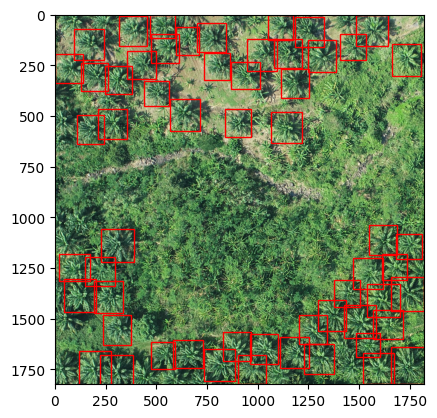

Prediction:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


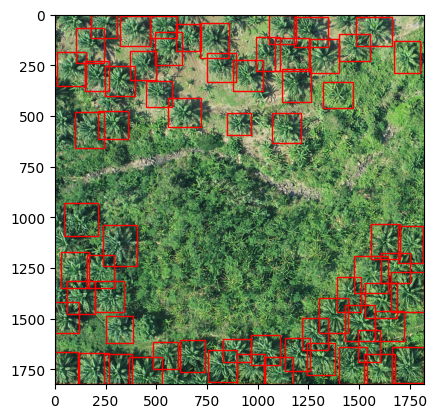

Jumlah label ground truth: 57
Jumlah label hasil prediksi: 65
Jumlah label yang sesuai antara ground truth dan prediksi: 57
Accuracy: 100.00%


In [ ]:
# GPU index untuk data yang digunakan
_idx = 1

# Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

# Pindahkan gambar ke CPU untuk visualisasi
imgs_cpu = imgs[_idx].cpu()

# Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()}

# Visualisasikan gambar dan anotasi (ground truth)
plot_image_from_output(imgs_cpu, annotations_cpu)

# Pindahkan prediksi ke CPU
pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()}

# Visualisasikan gambar dan prediksi
print("Prediction: ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)

# Hitung label ground truth dan prediksi
ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
predicted_labels = pred[_idx]['labels'].cpu().numpy()

# Jumlah label asli (ground truth) dan hasil prediksi
print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

# Menyesuaikan panjang array jika ground truth dan prediksi berbeda panjang
min_length = min(len(ground_truth_labels), len(predicted_labels))

# Membandingkan hanya label yang sesuai dengan panjang terkecil
matches = np.sum(ground_truth_labels[:min_length] == predicted_labels[:min_length])
print(f"Jumlah label yang sesuai antara ground truth dan prediksi: {matches}")

# Menampilkan persentase kecocokan
accuracy = matches / min_length * 100
print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!mv /content/Tutorial-Book-Utils/utils_ObjectDetection.py /content/

In [ ]:
import utils_ObjectDetection as utils

# Menghitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Output hasil evaluasi
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy.item()}')

Precision: tensor([0.9559])
Recall: tensor([0.9447])
F1-score: tensor([0.9502])
Accuracy: 0.9558509588241577


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.936286895249403
AP : tensor([0.9363], dtype=torch.float64)


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Menghitung Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE)
def calculate_mse_rmse(pred_labels, true_labels):
    """ Menghitung MSE dan RMSE """
    if len(pred_labels) != len(true_labels):
        raise ValueError("Jumlah prediksi dan jumlah label harus sama.")

    # Menghitung MSE
    mse = torch.mean((pred_labels - true_labels) ** 2)
    rmse = torch.sqrt(mse)

    return mse.item(), rmse.item()

# Filter pred_scores dan true_labels untuk memastikan ukurannya sama
valid_indices = true_positives.nonzero(as_tuple=True)[0]  # Ambil indeks True Positives
filtered_pred_scores = pred_scores[valid_indices]
filtered_true_labels = torch.tensor(labels)[valid_indices]

# Hitung MSE dan RMSE
mse, rmse = calculate_mse_rmse(filtered_pred_scores, filtered_true_labels)

# Output hasil MSE dan RMSE
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.0016742079751566052
Root Mean Squared Error (RMSE): 0.040917087346315384


#PREDIKSI NEW DATA

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


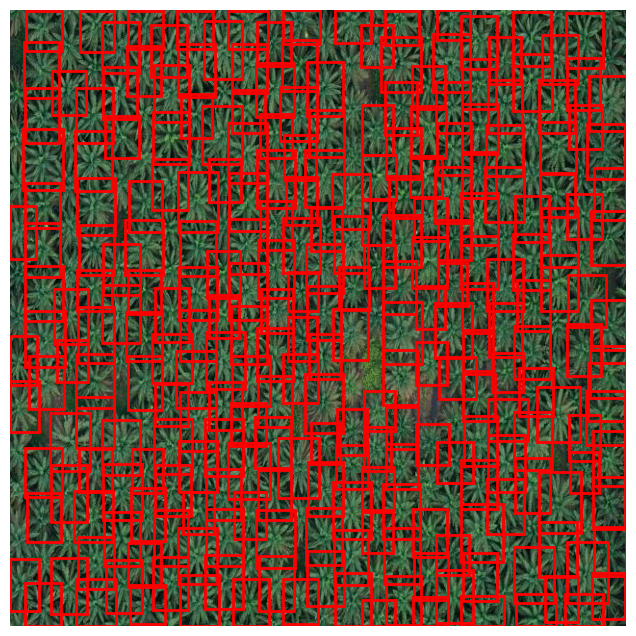

Jumlah kotak prediksi yang muncul: 263


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_60.pt'))  # Memuat model yang sudah dilatih
model.to(device)

def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Memuat gambar baru
img_path = '/content/sawit.jpg'
image = Image.open(img_path).convert("RGB")
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Melakukan prediksi
model.eval()
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.1
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah kotak prediksi yang muncul: {num_boxes}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


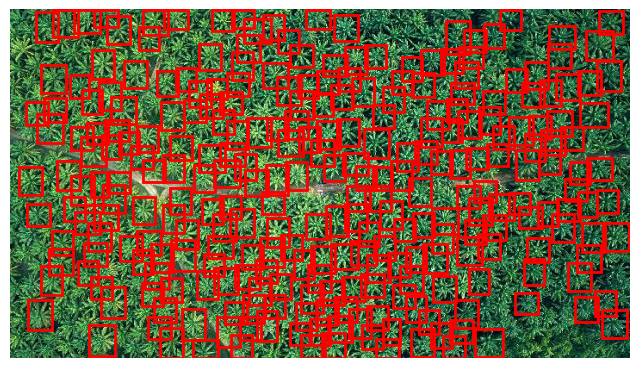

Jumlah kotak prediksi yang muncul: 273


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_60.pt'))  # Memuat model yang sudah dilatih
model.to(device)

def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Memuat gambar baru
img_path = '/content/sawit2.jpg'
image = Image.open(img_path).convert("RGB")
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Melakukan prediksi
model.eval()
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.1
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah kotak prediksi yang muncul: {num_boxes}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


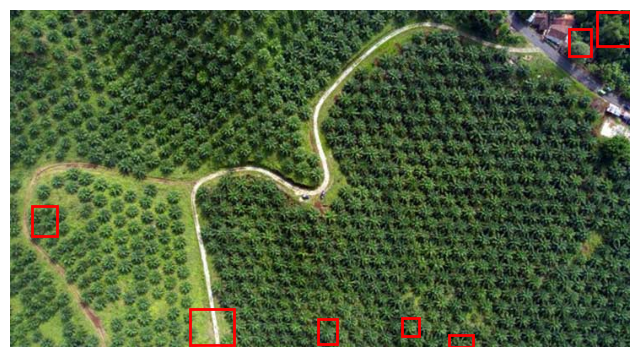

Jumlah kotak prediksi yang muncul: 7


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_60.pt'))  # Memuat model yang sudah dilatih
model.to(device)

def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Memuat gambar baru
img_path = '/content/sawit3.jpg'
image = Image.open(img_path).convert("RGB")
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Melakukan prediksi
model.eval()
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.1
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)

# Menghitung jumlah box (bounding boxes)
num_boxes = len(pred_boxes)
print(f"Jumlah kotak prediksi yang muncul: {num_boxes}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


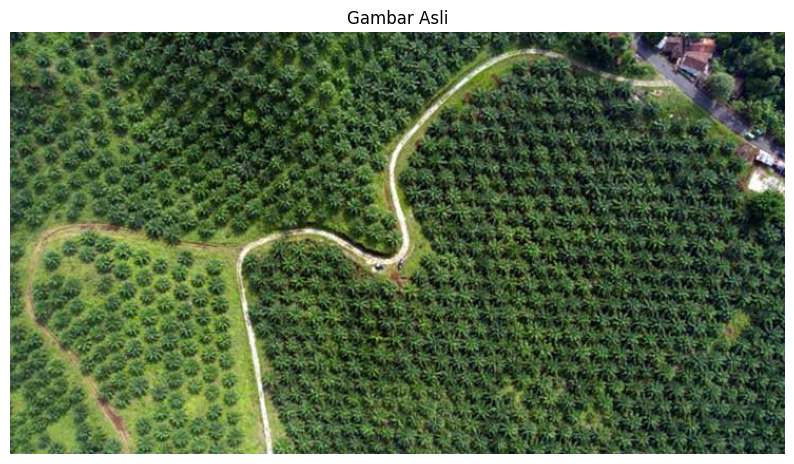

Prediksi untuk gambar crop ke-1:


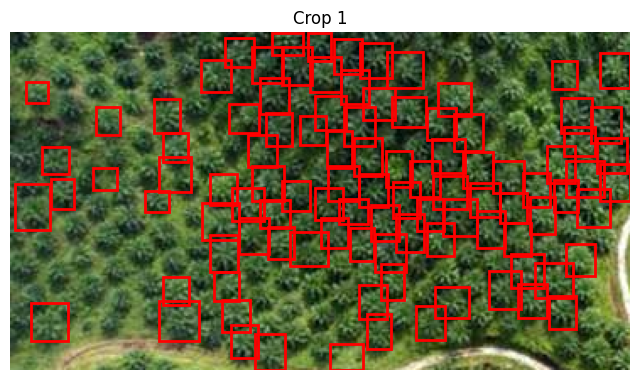

Jumlah label pada crop 1: 100
Prediksi untuk gambar crop ke-2:


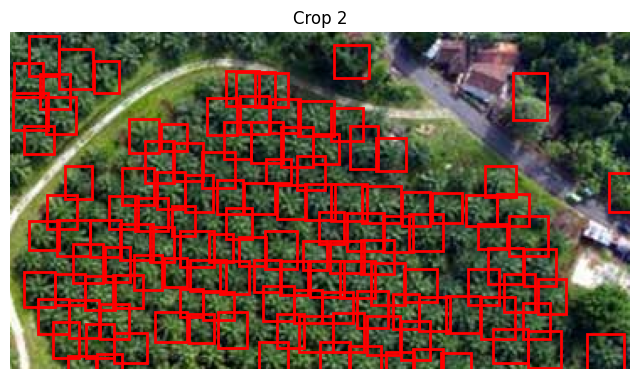

Jumlah label pada crop 2: 127
Prediksi untuk gambar crop ke-3:


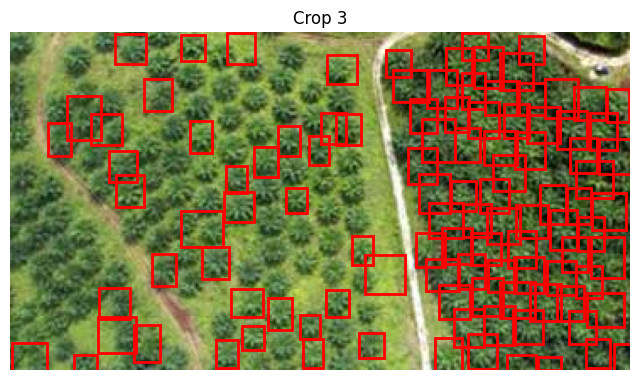

Jumlah label pada crop 3: 107
Prediksi untuk gambar crop ke-4:


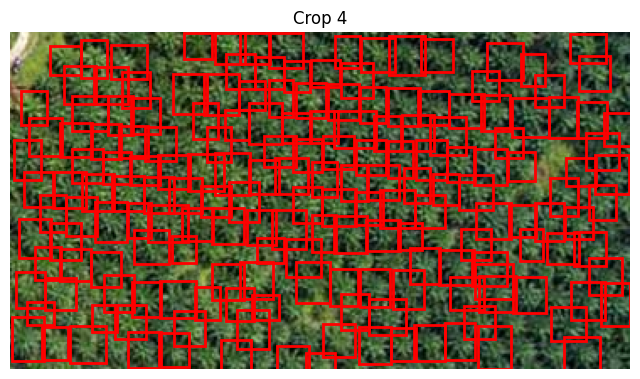

Jumlah label pada crop 4: 180
Jumlah total label dari keempat crop gambar: 514


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_60.pt'))  # Memuat model yang sudah dilatih
model.to(device)

def plot_image_with_boxes(image, boxes, labels, title="Predicted Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Menghilangkan label angka, cukup menampilkan string kosong
        ax.text(xmin, ymin, '', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.title(title)
    plt.axis('off')
    plt.show()

def predict_on_image(image, model, device, threshold=0.01):
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

    # Melakukan prediksi
    model.eval()
    with torch.no_grad():
        pred = model(image_tensor)

    # Menyaring prediksi berdasarkan skor
    pred_boxes = []
    pred_labels = []
    for idx in range(len(pred)):
        for i, score in enumerate(pred[idx]['scores']):
            if score > threshold:
                pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
                pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

    return pred_boxes, pred_labels

# Memuat gambar baru
img_path = '/content/sawit3.jpg'
image = Image.open(img_path).convert("RGB")

# Menampilkan gambar asli
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Gambar Asli")
plt.axis('off')
plt.show()

# Mendapatkan dimensi gambar
width, height = image.size

# Membagi gambar menjadi 4 bagian
crop_areas = [
    (0, 0, width // 2, height // 2),  # Kiri atas
    (width // 2, 0, width, height // 2),  # Kanan atas
    (0, height // 2, width // 2, height),  # Kiri bawah
    (width // 2, height // 2, width, height)  # Kanan bawah
]

total_labels = 0  # Variabel untuk menghitung jumlah total label

for i, crop_area in enumerate(crop_areas, 1):
    cropped_image = image.crop(crop_area)  # Crop gambar
    pred_boxes, pred_labels = predict_on_image(cropped_image, model, device)

    # Menampilkan gambar hasil crop beserta prediksinya
    print(f"Prediksi untuk gambar crop ke-{i}:")
    plot_image_with_boxes(cropped_image, pred_boxes, pred_labels, title=f"Crop {i}")

    # Menampilkan jumlah label pada crop gambar
    print(f"Jumlah label pada crop {i}: {len(pred_labels)}")

    # Mengakumulasi jumlah label dari semua crop
    total_labels += len(pred_labels)

# Menampilkan jumlah total label dari 4 gambar crop
print(f"Jumlah total label dari keempat crop gambar: {total_labels}")
